
(done)     1 - ROUTE CALCULATION BETWEEN TWO COORDINATES:

(not done) 2 - Pool of routes to consider joining many routes if they cross. 
*select close routes
*join close routes
*recalculate

Easy part first, calculate routes with just two points; 

1.0 - Load coordinates of target and source.
1.1 - Process the coordinates as a Shapely points instances.
1.2 - Define a polygon containing the shapes.
1.3 - Download the graph that contains that polygon. Predefined if its car or walkable route 
1.4 - Define best order of nodes in route
1.5 - Plot in MapBox.

The next steps are in the end of notebook.



In [1]:
# 1.0 - Load coordinates of target and source


#shapely manage polygons, lines and points in a geoespacial way
import shapely

#Representation of point located in earth
from shapely.geometry import Point

""" I choosed aleatory points of my city for test. You can put coordinates anywhere in the world (if its mapped by OpenStreetMaps) """

#the point the user is headed
target =  {'type': 'Point',
            'coordinates': [-22.8944985,-43.1131766], #first value is latitude, second longitude. It could be inverted, no problems.
            'route_info': 'target',
            'motion':'walk', #the types should be ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, or ‘all_private’.
            'extra_info1': 'user_id', 
            'extra_info2': 'anything you want'}

#the point where the route start
source = {'type': 'Point',
            'coordinates': [-22.893526,-43.1110573], #first value is latitude, second longitude. It could be inverted, no problems.
            'route_info': 'source',
            'motion': 'walk', #the types should be ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, or ‘all_private’.
            'extra_info1': 'user_id', 
            'extra_info2': 'anything you want'}



In [2]:
#1.1 - Process the coordinates as a Shapely points instances.

#Shapely point should take coordinates as a (LONGITUDE, latitude) tuple instance
target_as_Point = Point(target['coordinates'][1], target['coordinates'][0])
source_as_Point = Point(source['coordinates'][1], source['coordinates'][0])

#Geopandas com manage geoespacial information.
import geopandas as gpd

#organize everything in a geodataframe called gdf. 
#crs is the coordinate system. usually is geographic wgs84 and has the code epsg = 4326
gdf = gpd.GeoDataFrame([target,source], geometry = [target_as_Point, source_as_Point], crs = 4326)

#just checking the coordinates
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

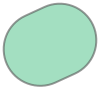

In [3]:
#1.2 - Define a polygon containing the shapes.

#geodataframe as unique element
unary = gdf.unary_union

#Draw a polygon that countains that unique group of elements.
pol = unary.convex_hull

#Get the region around that polygon. 0.004 is the radius of the buffer.
pol_buffed = pol.buffer(0.004)

#just printing the area containing the points
pol_buffed

In [20]:
#1.3 - Download the graph that contains that polygon. Predefined if its car or walkable route 
#that library is the api of OpenStreetMap
import osmnx as ox
from osmnx import graph_from_polygon

#Networkx is good library for Python management
import networkx as nx

#i'll bring the type of route by the "motion" column in geodataframe in variable gdf

type_of_route = gdf.set_index('extra_info1').loc['user_id'].motion.unique()[0]

#download the graph from open street map that is contained in that polygon
graph = graph_from_polygon(pol_buffed, network_type=type_of_route, simplify=False, retain_all=True, truncate_by_edge=False, clean_periphery=False)

""" If you need fast response you'll need to have the graph of all streets of the world in your server. Download big graphs is slow """

" If you need fast response you'll need to have the graph of all streets of the world in your server. Download big graphs is slow "

In [25]:
#1.4 - Define best order of nodes in route
import pandas as pd
#find the closest node to our target and register the distance between then in the column 'target_distance'

#coordinates as a (LATITUDE, longitude) tuple instance. 
gdf['coords_tuple'] = gdf.coordinates.map(tuple)

#calculate all closest graph nodes and their distances in a series "s_nodes_dist"
s_nodes_dist = pd.Series(gdf.coords_tuple.apply(lambda x: ox.get_nearest_node(graph, x, method='haversine', return_dist=True)))

#organize the node id and distance from user coordinates in our geodataframe.
gdf['node_id'] = s_nodes_dist.map(lambda x:x[0])
gdf['node_distance_meters'] = s_nodes_dist.map(lambda x:x[1])

#select the target and source nodes ids
target_mask = gdf.route_info == 'target'
source_mask = gdf.route_info == 'source'

target_node_id = gdf[target_mask].node_id.item()
source_node_id = gdf[source_mask].node_id.item()

#this path variable has the ids of the nodes in the shortest path
nodes_route_ordered = nx.shortest_path(graph, source = target_node_id, target = source_node_id, weight='length', method='dijkstra')

#python can only store lists in dataframes if the type of column is string
gdf['route_order'] = ''

#mask to link the user id caller "user_id", could be his login or id number.
mask_user_id = gdf[gdf.extra_info1=='user_id'].index[0]

#storing the route linked with the user.
gdf.at[mask_user_id, 'route_order'] = nodes_route_ordered

#I selected target to explode without duplicates in next lines
mask_gdf_subset = gdf.route_info == 'target' 

#I can't explode with geometry column
df_route = pd.DataFrame(gdf[mask_gdf_subset].drop(columns = 'geometry'))

#Explode!
df_route = df_route.explode('route_order').reset_index().rename(columns = {'index':'gdf_index'})


In [26]:
#1.5 - Plot in MapBox.


#create separeted columns for latitude and longitude
#first get graph coords
nodes_proj = ox.graph_to_gdfs(graph, nodes=True, edges=False)
df_route['lat'] = nodes_proj.loc[df_route.route_order].reset_index()['y']
df_route['lon'] = nodes_proj.loc[df_route.route_order].reset_index()['x']


#Just to create an ordered column
df_route.reset_index(inplace = True)

In [18]:
import plotly.express as px
import plotly.graph_objects as go

#please, use your token from MapBox
token = ''

px.set_mapbox_access_token(token)

In [32]:
#A look in the organized information about the nodes that compose the route, granting rastreability with route info.
df_route.columns

Index(['index', 'gdf_index', 'type', 'coordinates', 'route_info', 'motion',
       'extra_info1', 'extra_info2', 'coords_tuple', 'node_id',
       'node_distance_meters', 'route_order', 'lat', 'lon'],
      dtype='object')

In [34]:
px.set_mapbox_access_token(token)

#pontos da rota do grafo dos vertices
fig = px.scatter_mapbox(df_route, lat="lat", lon="lon", color="index", hover_name = "extra_info1", title = "Test Simple Route", color_continuous_scale=px.colors.sequential.Viridis, size_max=15, zoom=11)

#linha do mapa ,a partir dos nós ligados da subrota expandida
fig.add_trace(go.Scattermapbox(
    name = 'Draw of Route',
    mode = "lines",
    lon = df_route['lon'].to_list(),
    lat = df_route['lat'].to_list(),
    marker = {'size': 6}))

fig.update_layout(
    mapbox_style="streets",
    mapbox_layers=[
        {"below": 'traces'}],
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig.layout.coloraxis.colorbar.title.text = "Route ordinal order"

fig.show()

In [20]:



""" PLOT SUBROTAS EXPANDIDAS"""



#pontos da rota do grafo dos vertices
fig = px.scatter_mapbox(df_route, lat="lat", lon="lon", color="index",hover_name = 'extra_info2', title = 'Prototype Route', color_continuous_scale=px.colors.sequential.Viridis, size_max=15, zoom=11)

#linha do mapa ,a partir dos nós ligados da subrota expandida
fig.add_trace(go.Scattermapbox(
    name = 'Route',
    mode = "lines",
    lon = df_route['lon'].to_list(),
    lat = df_route['lat'].to_list(),
    marker = {'size': 6}))


fig.update_layout(
    mapbox_style="streets",
    mapbox_layers=[
        {"below": 'traces'}],
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig.layout.coloraxis.colorbar.title.text = "Route Sequence"

fig.show()

fig.write_html(fr"map.html")


2 - Pool of routes to consider joining many routes. if Routes cross join routes.

1.0 - Load coordinates of target and source, but will be more than 2 points.
1.1 - Process the coordinates as a Shapely points instances.
2.1 - Cluster points. - Not sure how yet, because we have geographic coordinates.
1.2 - Define a polygon or polygons containing the shapes.
1.3 - Download the graph that contains that polygon(s). Predefined if its car or walkable route 
1.4 - Define best order of nodes in route
2.2 - Create a Shapely LineString, buffer for 300m and check intersection between routes
2.3 - With the intersections
2.3.1 - Replace old route with new route from source until intersection
2.3.2 - Make a new route, from intersection, dividing trips in vehicles with 4 people capacity
2.3.2.1 - Calculate Distance matrix - With my function
2.3.2.2 - Redistribute routes with OR-Tools - With Route Optimization
2.3.2.3 - Organize data - To be compatible with mongo database and MapBox.
2.4 - Consolidate all in a dataframe. 
1.5 - Plot all routes in one unique MapBox.
